In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_on_random, evaluate_on_data, evaluate_on_images, 
    plot_calculation_times_and_niter
)

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

## Evaluate All Algorithms


Testing on random generated tensors:
Dimension of tensor: (10, 10, 10), noise: 0.05304106028991461, F: 2, norm: 403.86126259678224
Multiplicative converged in 0.396 seconds and 578 iterations
Multiplicative Poisson converged in 0.511 seconds and 416 iterations
Geometric step size calculation without rescaling converged in 0.474 seconds and 79 iterations
Geometric step size calculation with normalization converged in 0.159 seconds and 48 iterations
Geometric step size calculation with max = 1 converged in 0.578 seconds and 139 iterations
Geometric step size calculation with mean = 1 converged in 0.461 seconds and 101 iterations
Geometric fixed step size converged in 2.568 seconds and 2001 iterations
Dimension of tensor: (20, 20, 5), noise: 0, F: 5, norm: 119.65436090175149
Multiplicative converged in 1.153 seconds and 1545 iterations
Multiplicative Poisson converged in 3.015 seconds and 1309 iterations
Geometric step size calculation without rescaling converged in 2.678 seconds and 415

C:\Users\David\Documents\GitHub\GeometricTensorFactorization\tensorfactorization\poisson.py:146: BacktrackingWarning: Backtracking did not converge in time so we skip this update.
  warnings.warn("Backtracking did not converge in time so we skip this update.", BacktrackingWarning)


NEXT ITERATE: smallest: tensor(0.0722, device='cuda:0'), biggest: tensor(1.4097, device='cuda:0'), average: tensor(0.8034, device='cuda:0')
KHATRI RAO PRODUCT: smallest: tensor(0., device='cuda:0'), biggest: tensor(0., device='cuda:0'), average: tensor(0., device='cuda:0')
APPROXIMATED X: smallest: tensor(1.1921e-07, device='cuda:0'), biggest: tensor(1.1921e-07, device='cuda:0'), average: tensor(1.1921e-07, device='cuda:0')
A_ns[0]: smallest: tensor(0.1358, device='cuda:0'), biggest: tensor(3.7625, device='cuda:0'), average: tensor(1.0402, device='cuda:0')
A_ns[1]: smallest: tensor(1.0586e-24, device='cuda:0'), biggest: tensor(5.1680e+37, device='cuda:0'), average: tensor(1.7227e+36, device='cuda:0')
A_ns[2]: smallest: tensor(0., device='cuda:0'), biggest: tensor(0., device='cuda:0'), average: tensor(0., device='cuda:0')
A_ns[3]: smallest: tensor(0.0525, device='cuda:0'), biggest: tensor(1.5339, device='cuda:0'), average: tensor(0.7492, device='cuda:0')
A_ns[4]: smallest: tensor(0.0722

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(



Testing on indian_pines data:
Tensor is of shape: torch.Size([145, 145, 200])
Multiplicative converged in 0.995 seconds and 528 iterations
Multiplicative Poisson converged in 2.107 seconds and 544 iterations
#### PRINTING ADDITIONAL INFORMATION ####
Current iteration: 1
Current index: 0
Step Size: 1.8991135491519597e-65
m: 214
Step size * biggest element of negative gradient: tensor(-0., device='cuda:0')
biggest element in A_n: tensor(33.0368, device='cuda:0')
smallest element in A_n: tensor(0.0198, device='cuda:0')
Shape of approximated_X_unfolded_n: torch.Size([145, 29000])
Shape of khatri Rao product: torch.Size([29000, 4])

Poisson error of current iteration: tensor(1.7781e+11, device='cuda:0')
norm of Riemannian Gradient: tensor(0., device='cuda:0')
poisson error of next iteration: tensor(inf, device='cuda:0')

Printing additional tensor information
TENSOR: smallest: tensor(955., device='cuda:0'), biggest: tensor(9604., device='cuda:0'), average: tensor(2652.3889, device='cuda:0'

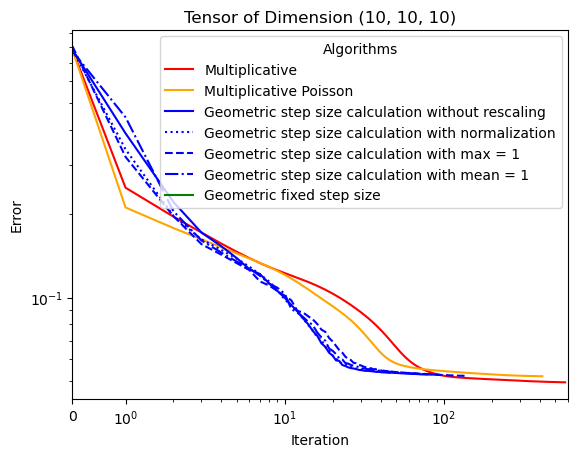

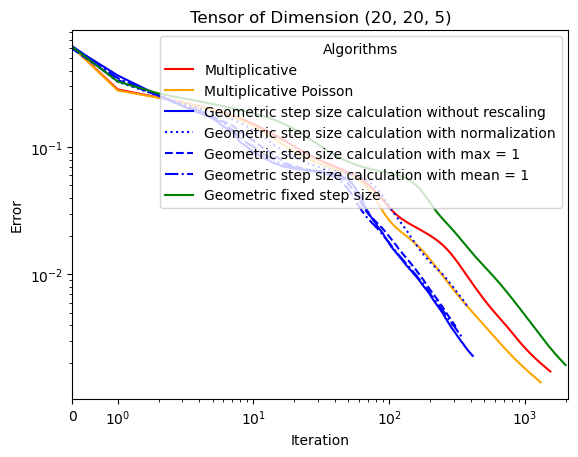

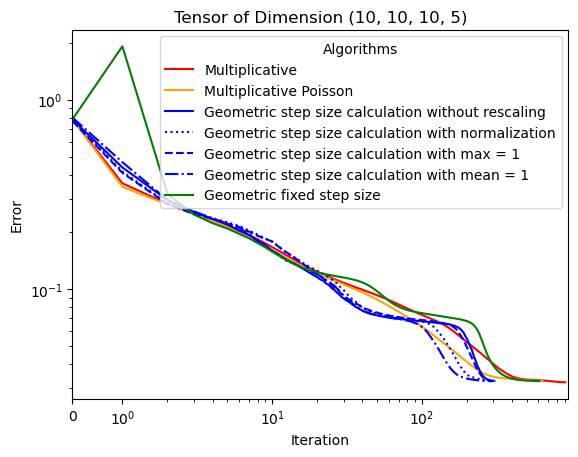

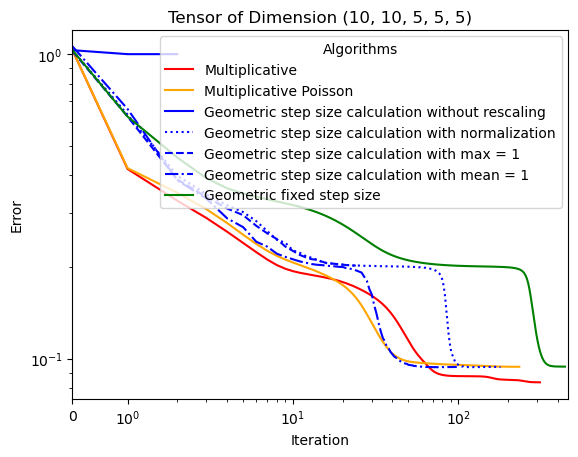

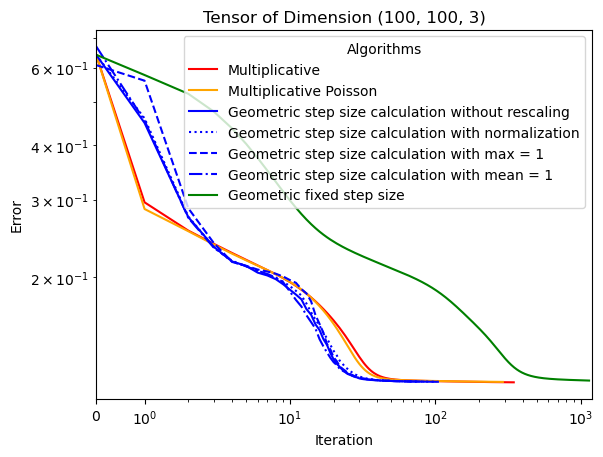

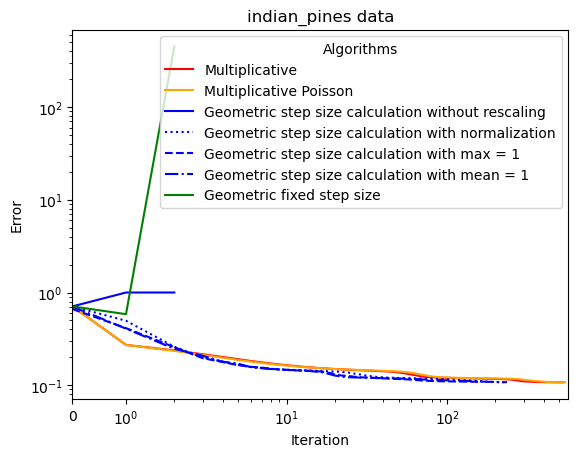

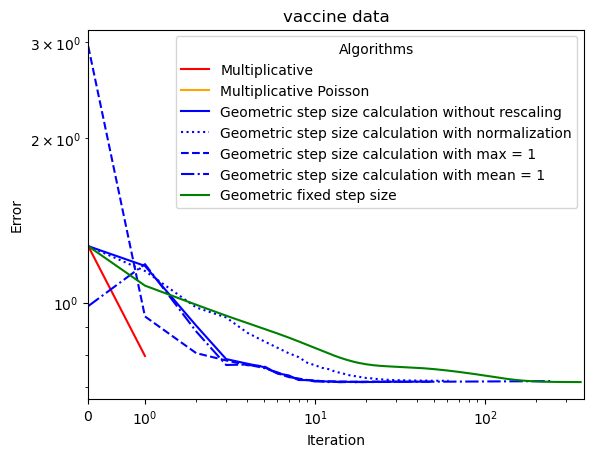

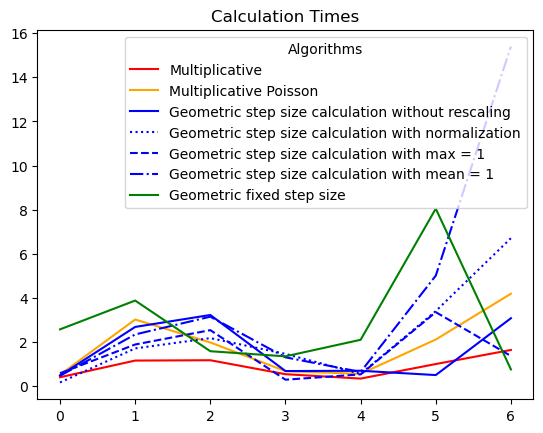

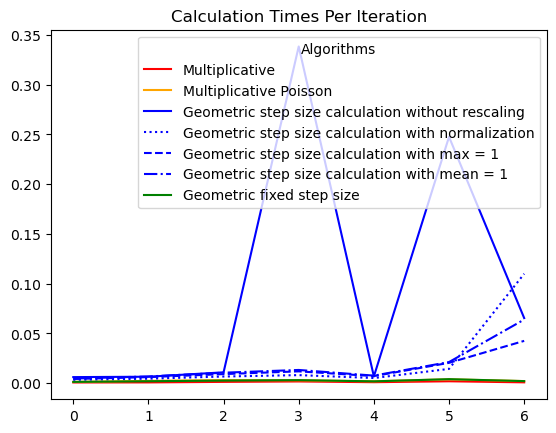

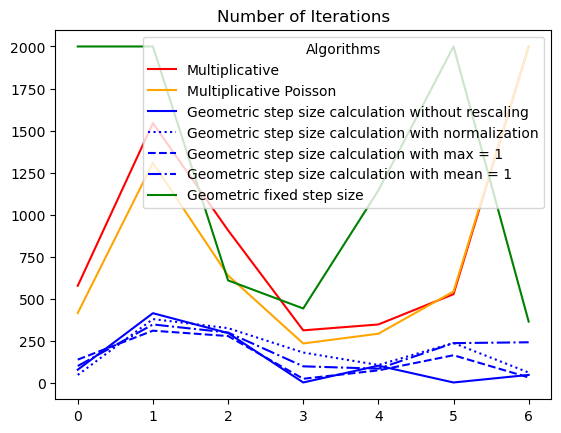

In [2]:
# CREATE FACTORIZER OBJECTS FOR ALL ALGORITHMS
max_iter = 2000

# The standart multiplicative algorithm
def multiplicative_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

# The Poisson variant of the multiplicative algorithm
def multiplicative_poisson_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')


# The new geometric algorithm with step size calculation and without any form of normalization
def geometric_variable_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric = Factorizer("Geometric step size calculation without rescaling", geometric_variable_step_size, color='blue')

# The new geometric algorithm with step size calculation and but normalization of the tensor and the initial data
def geometric_variable_normalized(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    norm_of_tensor = tl.norm(tensor)
    tensor_copy = tensor / norm_of_tensor # normalize tensor
    norm_of_approximation = tl.norm(defactorizing_CP(initial_A_ns, tensor.shape))
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / norm_of_approximation) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_norm = Factorizer("Geometric step size calculation with normalization", geometric_variable_normalized, color='blue', linestyle='dotted')

# The new geometric algorithm with step size calculation and but max=1 of the tensor and the initial data
def geometric_variable_normalize_max(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.max(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.max(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_max = Factorizer("Geometric step size calculation with max = 1", geometric_variable_normalize_max, color='blue', linestyle='dashed')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_variable_normalize_mean(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='dashdot')



# default geometric algorithm with fixed step size. Use normalize the mean of the tensor to get some form of normalization
def geometric_fixed_step_size(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_fixed_step_size(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_fixed = Factorizer("Geometric fixed step size", geometric_fixed_step_size, color='green')


# run the factorization on gpu
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
#context = {}
factorizers = [
    factorizer_multiplicative,
    factorizer_multiplicative_poisson,
    factorizer_geometric,
    factorizer_geometric_norm,
    factorizer_geometric_max,
    factorizer_geometric_mean,
    factorizer_geometric_fixed,
]
evaluate_on_random(factorizers, context=context)
evaluate_on_data(factorizers, context=context)
#evaluate_on_images(factorizers, context=context)
plot_calculation_times_and_niter(factorizers)